# Курсовая работа по Машинному обучению 
# Разработка системы анализа корпоративных новостей
## студентки 2 курса группы ПМ21-4
## Ермолиной Елизаветы

# Структура

1. Цель: провести анализ методов машинного обучения для обработки данных корпоративного новостного потока;
2. Задачи: загрузить данные, провести описательный анализ данных, провести предварительный анализ и очистку данных, провести векторизацию данных, разделить data set на тренировочные и тестовые значения, построить несколько моделей, построить результат моделирования
3. Ожидаемые результаты: выявить, какой метод наиболее эффективен для классификации новостей по тематическим областям;
4. Описание датасета: парсинг сайта Яндекс, данные преобразованы в csv файл, который состоит из 825 новостей, разделенные на пять тематических областей (Продукты, услуги и новые технологии, Отчетность и финансовые показатели,  Структура бизнеса, Политика компании и внутренние решения и другое) за 1996-2023 годы.

# Содержание

## [Парсинг](#Сбор_данных)
## [Очистка и преобразование данных](#Очистка_и_преобразование_данных)
## [Классификация датасета](#Классификация_датасета)
## [Векторизация текстовых данных ](#Векторизация_текстовых_данных)
## [Создание классификаторов ML](#Создание_классификаторов_ML)
## [Улучшение модели](#Улучшение_модели)
## [Нейросеть](#Нейросеть)
## [Выводы](#Выводы)
## [Список литературы](#Список_литературы)

## Импортируем все необходимые библиотеки

In [34]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import pymorphy2
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import numpy as np
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from urllib.parse import urlparse
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec, KeyedVectors
from sklearn import feature_extraction, svm
from tensorflow.keras import models, layers
from sklearn.metrics import  accuracy_score
import tensorflow as tf
#nltk.download('stopwords')
#nltk.download('punkt')
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from gensim import matutils
from sklearn import metrics, svm, neighbors, neural_network, tree, naive_bayes, datasets, ensemble, linear_model

2023-05-24 16:09:08.919806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Парсинг

 собираем данные со следующих сайтов: 

1. РБК (раздел "Бизнес") - https://www.rbc.ru/business/?utm_source=topline

2. B2Broker - https://b2broker.com/ru/corporate-news/

3. Yandex  - https://yandex.ru/company/press_releases/2023

### РБК бизнес

In [ ]:
RBC = pd.DataFrame(columns = ['Title','Link', 'Text'])
url = 'https://www.rbc.ru/business/?utm_source=topline'
USER = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.3 Safari/605.1.15"}
result = requests.get(url, headers=USER)
soup = BeautifulSoup(result.content,'html.parser')
titles = soup.find_all('span', class_='item__title rm-cm-item-text js-rm-central-column-item-text')
domain_name = urlparse('https://www.rbc.ru/business/?utm_source=topline').netloc
soup = BeautifulSoup(requests.get(url).content, "html.parser")
links = []
texts = []
for a_tag in soup.findAll("a", class_='item__link rm-cm-item-link js-rm-central-column-item-link'):
        href = a_tag.attrs.get("href")
        links.append(href)
        
        res = requests.get(href, headers=USER)
        soup_ = BeautifulSoup(res.content,'html.parser')
        text = soup_.findAll('div', class_='article__text article__text_free')
        texts.append(str(text[0].text).replace('\n', ' ').replace('\xa0', ' '))
i = 1
for t, l, tex in zip(titles, links, texts):
    RBC.loc[i] = [t.get_text().strip(), l, tex]
    i += 1

### B2Broker

In [ ]:
B2B = pd.DataFrame(columns = ['Title','Link', 'Text'])
for p in range(1, 5):
    url = f'https://b2broker.com/ru/corporate-news/page/{p}/'
    USER = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.3 Safari/605.1.15"}
    result = requests.get(url, headers=USER)
    soup = BeautifulSoup(result.content,'html.parser')
    titles = soup.find_all('div', class_='b2b_event_main_content_box_info_title')
    
    links = []
    texts = []
    for n in range(1, 13):
        for a_tag in soup.findAll("a", class_=f'b2b_event_main_content_box box_number_{n}'):
                href = a_tag.attrs.get("href")
                links.append(href)

                res = requests.get(href, headers=USER)
                soup_ = BeautifulSoup(res.content,'html.parser')
                text = soup_.findAll('div', class_='publication_body_content_gutenberg')

                texts.append(text[0].text.replace('\n', ' ').replace('\xa0', ' '))
    
    i = (p-1)*12 + 1
    for t, l, tex in zip(titles, links, texts):
        B2B.loc[i] = [t.get_text().strip(), l, tex]
        i += 1

### Яндекс

In [ ]:
YNDX = pd.DataFrame(columns = ['Title','Link','Text'])
c = 0
for y in range(2010, 2024): 
    url = f'https://yandex.ru/company/press_releases/{y}'
    USER = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.3 Safari/605.1.15"}
    result = requests.get(url, headers=USER)
    soup = BeautifulSoup(result.content,'html.parser')

    links = []
    texts = []
    titles = []
    for t in soup.find_all('div', class_='pr-item pr-list__item'):
        text = t.text
        text = re.search(r'([A-Z]|[А-Я]|[a-z]).*', f'{text}')
        titles.append(text[0])
        c += 1
    t = soup.find_all('a', class_='link link_theme_normal i-bem')
    links.extend(list(map(lambda B: 'https://yandex.ru'+str(B.get('href')),filter(lambda x: f'{y}' in str(x.get('href')) ,t))))
    for l in links:
        res = requests.get(l, headers=USER)
        soup_ = BeautifulSoup(res.content,'html.parser')
        A = soup_.get_text().replace('\xa0', ' ')
        A = A.split('ЯндексКомпанияБлогВакансииРазработчикамРекламодателямСобытияНаукаОбучениеО компанииКонфиденциальностьИсторияНовостиИсследованияТехнологииОфисыКонтакты ')[1].split('КонтактыКомпания «Яндекс»')[0]
        texts.append(A)
   
    i = YNDX.shape[0] + 1
    #print(y)
    for t, l, tex in zip(titles, links, texts):
        YNDX.loc[i] = [t, l, tex]
        i += 1

In [ ]:
YNDX1 = pd.DataFrame(columns = ['Title','Link','Text'])
c = 0
for y in range(1996, 2006):
    start = c
    url = f'https://yandex.ru/company/press_releases/{y}'
    USER = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.3 Safari/605.1.15"}
    result = requests.get(url, headers=USER)
    soup = BeautifulSoup(result.content,'html.parser')

    links = []
    texts = []
    titles = []
    for t in soup.find_all('div', class_='pr-item pr-list__item'):
        text = t.text
        text = re.search(r'([A-Z]|[А-Я]|[a-z]).*', f'{text}')
        titles.append(text[0])
        c += 1
    t = soup.find_all('a', class_='link link_theme_normal i-bem')
    links.extend(list(map(lambda B: 'https://yandex.ru'+str(B.get('href')),filter(lambda x: f'{y}' in str(x.get('href')) ,t))))
    for l in links:
        res = requests.get(l, headers=USER)
        soup_ = BeautifulSoup(res.content,'html.parser')
        A = soup_.get_text().replace('\xa0', ' ')
        A = A.split('ЯндексКомпанияБлогВакансииРазработчикамРекламодателямСобытияНаукаОбучениеО компанииКонфиденциальностьИсторияНовостиИсследованияТехнологииОфисыКонтакты ')[1].split('КонтактыКомпания «Яндекс»')[0]
        texts.append(A)
    i = YNDX1.shape[0] + 1
    #print(y)
    for t, l, tex in zip(titles, links, texts):
        YNDX1.loc[i] = [t, l, tex]
        i += 1

In [ ]:
YNDX2 = pd.DataFrame(columns = ['Title','Link', 'Text'])
c = 0
for y in range(2008, 2010):
    url = f'https://yandex.ru/company/press_releases/{y}'
    USER = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.3 Safari/605.1.15"}
    result = requests.get(url, headers=USER)
    soup = BeautifulSoup(result.content,'html.parser')

    links = []
    texts = []
    titles = []
    for t in soup.find_all('div', class_='pr-item pr-list__item'):
        text = t.text
        text = re.search(r'([A-Z]|[А-Я]|[a-z]|50).*', f'{text}')
        titles.append(text[0])
        
    t = soup.find_all('a', class_='link link_theme_normal i-bem')
    links.extend(list(map(lambda B: 'https://yandex.ru'+str(B.get('href')),filter(lambda x: f'{y}' in str(x.get('href')) ,t))))
    for l in links:
        res = requests.get(l, headers=USER)
        soup_ = BeautifulSoup(res.content,'html.parser')
        A = soup_.get_text().replace('\xa0', ' ')
        A = A.split('ЯндексКомпанияБлогВакансииРазработчикамРекламодателямСобытияНаукаОбучениеО компанииКонфиденциальностьИсторияНовостиИсследованияТехнологииОфисыКонтакты ')[1].split('КонтактыКомпания «Яндекс»')[0]
        texts.append(A)
   
    i = YNDX2.shape[0] + 1
    #print(y)
    for t, l, tex in zip(titles, links, texts):
        YNDX2.loc[i] = [t, l, tex]
        i += 1

In [ ]:
F_YNDX = YNDX1.append(YNDX2, sort=False) # датасет с новостями Яндекса: 825 новостей
F_YNDX = F_YNDX.append(YNDX, sort=False)

In [ ]:
F_YNDX = F_YNDX.reset_index()
F_YNDX = F_YNDX.iloc[:, 1:]
F_YNDX

,Title,Link,Text
0,Yandex.ru переехал в новое место (МТУ-Информ)....,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Yandex.ru становится станда...
1,Yandex.ru становится стандартным средством пои...,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Новое лицо yandex.ru. Естес...
2,Новое лицо yandex.ru. Естественно-языковый зап...,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Web - гуманизм или чернуха?...
3,Ранжирование результата поиска. Открыт пользов...,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Запущена новая поисковая ма...
4,В «Академическом поиске» появилась возможность...,https://yandex.ru/company/press_releases/1998/...,Главные новости1998Сцены из жизни поисковой ма...
...,...,...,...
822,Яндекс Лавку возглавит Вадим Петров,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Яндекс Лавку возглавит Вади...
823,Дмитрий Масюк возглавит бизнес-группу Поиска и...,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Дмитрий Масюк возглавит биз...
824,Публикация кода: Яндекс раскрывает первые резу...,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Публикация кода: Яндекс рас...
825,Нейросети Яндекса расшифруют архивные рукописн...,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Нейросети Яндекса расшифрую...


In [ ]:
# загрузка датасета в файл csv
#F_YNDX.to_csv(r'/Users/liza/Desktop/Учеба/Курсовая/full_yandex.csv', index=False)

In [ ]:
#B2B.to_csv(r'/Users/liza/Desktop/Учеба/Курсовая/B2Broker.csv', index=False)

In [ ]:
#RBC.to_csv(r'/Users/liza/Desktop/Учеба/Курсовая/RBC.csv', index=False)

###### Получаем датасет на 825 корпоративных новостей Яндекса на различные тематики. 
##### 1 - Продукты, услуги и новые технологии, 2 - Отчетность и финансовые показатели, 3 - Структура бизнеса (в т.ч. сделки) ,  4 - Политика компании и внутренние решения, 5 - Другое 

In [40]:
data_yandex = pd.read_csv('full_yandex.csv') 
data_yandex

,Title,Link,Text
0,Yandex.ru переехал в новое место (МТУ-Информ)....,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Yandex.ru становится станда...
1,Yandex.ru становится стандартным средством пои...,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Новое лицо yandex.ru. Естес...
2,Новое лицо yandex.ru. Естественно-языковый зап...,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Web - гуманизм или чернуха?...
3,Ранжирование результата поиска. Открыт пользов...,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Запущена новая поисковая ма...
4,В «Академическом поиске» появилась возможность...,https://yandex.ru/company/press_releases/1998/...,Главные новости1998Сцены из жизни поисковой ма...
...,...,...,...
820,Яндекс Лавку возглавит Вадим Петров,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Яндекс Лавку возглавит Вади...
821,Дмитрий Масюк возглавит бизнес-группу Поиска и...,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Дмитрий Масюк возглавит биз...
822,Публикация кода: Яндекс раскрывает первые резу...,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Публикация кода: Яндекс рас...
823,Нейросети Яндекса расшифруют архивные рукописн...,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Нейросети Яндекса расшифрую...


Описание данных:
825 строк
1. Title - заголовок новости 

2. Link -  ссылка на новость

3. Text - текст новости

# Очистка и преобразование данных

In [43]:
# для начала нам необходимо удалить все лишние знаки

cleaned_data = data_yandex['Text'].apply(lambda x: re.sub(re.compile('[^А-Яа-яA-Za-z0-9]+'), ' ', x))
 # оставим в текстах новостей только слова (без знаков)
cleaned_data = cleaned_data.apply(lambda x: x.lower()) # для обработки слов 

# разделим текст новости на отдельные слова
tokenized_data = cleaned_data.apply(lambda x: word_tokenize(x))

stop_words = stopwords.words("russian") # используем пакет стоп-слов на русском

filtered_data = tokenized_data.apply(lambda x: [word for word in x if word not in stop_words])
# удаление стоп слов

In [44]:
# стеммизация - процесс приведения слова к его корню/основе
stemmer = SnowballStemmer("russian") 

stemmed_data = filtered_data.apply(lambda x:[stemmer.stem(word) for word in x])
stemmed_data # этот метод убирает окончания, соответсвенно, он нам не подходит в случае
# слова "главный", его он преобразует в "главн", что нам не подходит

0      [главн, новости1997ыандеx, ru, станов, стандар...
1      [главн, новости1997нов, лиц, yandex, ru, естес...
2      [главн, новости1997wеб, гуманизм, чернух, сего...
3      [главн, новости1997запущ, нов, поисков, машин,...
4      [главн, новости1998сц, жизн, поисков, машиныз,...
                             ...                        
820    [главн, новости2023яндекс, лавк, возглав, вад,...
821    [главн, новости2023дмитр, масюк, возглав, бизн...
822    [главн, новости2023публикац, код, яндекс, раск...
823    [главн, новости2023нейросет, яндекс, расшифр, ...
824    [главн, новости2023яндекс, такс, запуска, нов,...
Name: Text, Length: 825, dtype: object

In [45]:
# чтобы правильно провести стемматизацию воспользуемся библиотекой pymorphy2

morph = pymorphy2.MorphAnalyzer()
morph_data = filtered_data.apply(lambda x:[morph.parse(word)[0].normal_form for word in x][2:])

In [46]:
morph_data 

0      [ru, становиться, стандартный, средство, поиск...
1      [лицо, yandex, ru, естественно, языковый, запр...
2      [гуманизм, чернуха, сегодня, точно, ответить, ...
3      [новый, поисковый, машина, яndex, web23, сентя...
4      [жизнь, поисковый, машиныз, год, жизнь, yandex...
                             ...                        
820    [лавка, возглавить, вадим, петровнов, глава, я...
821    [масюк, возглавить, бизнес, группа, поиск, рек...
822    [код, яндекс, раскрывать, первый, результат, р...
823    [яндекс, расшифровать, архивный, рукописный, д...
824    [такси, запускать, новый, финансовый, сервис, ...
Name: Text, Length: 825, dtype: object

In [47]:
morph_data = morph_data.apply(lambda x: ' '.join(x)) # приводим к строковому типу
morph_data

0      ru становиться стандартный средство поиск русс...
1      лицо yandex ru естественно языковый запрос 18 ...
2      гуманизм чернуха сегодня точно ответить гумани...
3      новый поисковый машина яndex web23 сентябрь 19...
4      жизнь поисковый машиныз год жизнь yandex ru ад...
                             ...                        
820    лавка возглавить вадим петровнов глава яндекс ...
821    масюк возглавить бизнес группа поиск рекламный...
822    код яндекс раскрывать первый результат расслед...
823    яндекс расшифровать архивный рукописный докуме...
824    такси запускать новый финансовый сервис водите...
Name: Text, Length: 825, dtype: object

In [48]:
morph_data[1] # пример того, как выглядит обработанная новость

'лицо yandex ru естественно языковый запрос 18 ноябрь москва компания comptek сообщать оба открытие новый интерфейс поисковый машина yandex ru задать запрос естественный язык лишь общий вид представлять область поиск сторона язык запрос понятие релевантность яndex настолько развиться позволять успешно работать неформальный запрос задать запрос например русский кириллический шрифт windows получить список документ относиться дать тема часть который очередь дать дальнейший ссылка мочь регулировать мягкость запрос выбирать параметр поле сколько найти умолчание стоить параметр стоить изменять сторона увеличение документ найти сторона уменьшение мало найти слишком документ связь мягкость количество обратный мягкий запрос документ найтись статистика показывать менее десять процент пользователь хотя заходить страница http yandex ru ya detail html описать синтаксис запрос это понятно интернет начинаться инструмент учёный военный пользоваться человек технический специальность'

## Классификация датасета

In [129]:
development = ['распознавание','возможность','показание', 'выходить', 'рекомендации', 'образовательный',
               'научить', 'расшифровать','услуга','умный','дом', 'проект', 'анонсировать', 'эффективность',
               'большой', 'данные', 'обработка', 'моделирование', 'алгоритм', 'угадывать', 'исследовать', 
               'исследование', 'расширять', 'распознавание', 'персональный', 'поиск', 'пользователь',
               'рейтинг', 'машинный', 'перевод', 'технология', 'развитие', 'исследовать', 'сервис', 
               'фото', 'школа', 'нейросеть', 'искать','техника', 'интерфейс', 'доставка', 'мобильный', 'приложение', 'подписка', 'помочь', 'открыть',
            'персонализация', 'инновация', 'продукт', 'удобный', 'управление', 'сервис', 'облачный', 'открывать', 
           'выпустить', 'раздел', 'появиться', 'запускать', 'подписка', 'акция', 'просьба', 'реклама', 
           'карта', 'пользователь', 'общение', 'новый', 'возможность', 'искать', 'испытание', 
               'премьера', 'усилить', 'защита']
finance = ['квартал', 'прибыль', 'рентабельность', 'выручка', 'ликвидность', 'EBITDA', 'рост',
           'бухгалтерский', 'учет', 'доход',  'финансовый', 'результат', 'миллион', 'отчет', 'отчёт'] 
#EBITDA - объём прибыли до вычета расходов по выплате процентов, налогов, износа и начисленной амортизации
structure = ['офис', 'покупка', 'площадка', 'совместный', 'бизнес', 'выкуп', 'покупка', 'капитал', 'часть',
             'уход', 'компания', 'семейный', 'структура', 'договор', 'соглашение', 'владеть', 'владелец', 
             'назначать', 'возглавить', 'часть', 'договориться', 'возглавить', 'сотрудничество', 'переворот', 'информация', 
             'чистый','прибыль', 'приобрести', 'слияние', 'сделка', 'партнер', 'покупать', 'совладелец',
             'рынок', 'выходить', 'стать', 'закрыть', 'продать', 'генеральный', 'директор', 'бизнес', 'группа',
            'руководить', 'назначение', 'пост', 'он', 'вернуться', 'руководство', 'сотрудничество', 'договориться']
policy = ['регистрация', 'учетный', 'запись', 'изменение', 'управление', 'этика', 'правило', 'запрет',
          'помощь', 'изменить', 
          'апелляция', 'решение', 'делистинг', 'поддержка']
other = ['финал', 'полуфинал', 'кубок', 'заявление', 'премия', 'лауреат', 'фестиваль', 'премия', 'поздравление', 
         'марафон', 'стартовать', 'сбой', 'лучший', 'причина', 'участие', 'принять', 'приглашать', 'конкурс', 
        'встретиться', 'первый', 'тур', 'второй', 'семинар', 'урок', 'стипендия', 'заявка', 'кубок', 'чемпион']

### 1 - Продукты, услуги и новые технологии, 2 - Отчетность и финансовые показатели, 3 - Структура бизнеса (в т.ч. сделки) ,  4 - Политика компании и внутренние решения, 5 - Другое 

In [ ]:
data_yandex['Category'] = ['0']*data_yandex.shape[0]

In [ ]:
for x in range(len(morph_data)):
    c = [0]*5
    for j in morph_data[x]:
        if j in development: 
            c[0] += 1
        elif j in finance:
            c[1] += 1
        elif j in structure:
            c[2] += 1
        elif j in policy:
            c[3] += 1
        elif j in other:
            c[4] += 1
    if max(c) > 3:
        max_ind = c.index(max(c))
        data_yandex['Category'][x] = max_ind+1
    else:
        data_yandex['Category'][x] = 5
data_yandex

,Title,Link,Text,Category
0,Yandex.ru переехал в новое место (МТУ-Информ)....,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Yandex.ru становится станда...,5
1,Yandex.ru становится стандартным средством пои...,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Новое лицо yandex.ru. Естес...,5
2,Новое лицо yandex.ru. Естественно-языковый зап...,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Web - гуманизм или чернуха?...,5
3,Ранжирование результата поиска. Открыт пользов...,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Запущена новая поисковая ма...,5
4,В «Академическом поиске» появилась возможность...,https://yandex.ru/company/press_releases/1998/...,Главные новости1998Сцены из жизни поисковой ма...,5
...,...,...,...,...
820,Яндекс Лавку возглавит Вадим Петров,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Яндекс Лавку возглавит Вади...,5
821,Дмитрий Масюк возглавит бизнес-группу Поиска и...,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Дмитрий Масюк возглавит биз...,5
822,Публикация кода: Яндекс раскрывает первые резу...,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Публикация кода: Яндекс рас...,5
823,Нейросети Яндекса расшифруют архивные рукописн...,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Нейросети Яндекса расшифрую...,5


In [ ]:
#data_yandex.to_csv(r'/Users/liza/Desktop/Учеба/Курсовая/class_yandex.csv', index=False)

In [59]:
yandex = pd.read_csv('class_yandex.csv') 
yandex

,Title,Link,Text,Category
0,Yandex.ru переехал в новое место (МТУ-Информ)....,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Yandex.ru становится станда...,1
1,Yandex.ru становится стандартным средством пои...,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Новое лицо yandex.ru. Естес...,1
2,Новое лицо yandex.ru. Естественно-языковый зап...,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Web - гуманизм или чернуха?...,5
3,Ранжирование результата поиска. Открыт пользов...,https://yandex.ru/company/press_releases/1997/...,Главные новости1997Запущена новая поисковая ма...,1
4,В «Академическом поиске» появилась возможность...,https://yandex.ru/company/press_releases/1998/...,Главные новости1998Сцены из жизни поисковой ма...,1
...,...,...,...,...
820,Яндекс Лавку возглавит Вадим Петров,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Яндекс Лавку возглавит Вади...,3
821,Дмитрий Масюк возглавит бизнес-группу Поиска и...,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Дмитрий Масюк возглавит биз...,3
822,Публикация кода: Яндекс раскрывает первые резу...,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Публикация кода: Яндекс рас...,1
823,Нейросети Яндекса расшифруют архивные рукописн...,https://yandex.ru/company/press_releases/2023/...,Главные новости2023Нейросети Яндекса расшифрую...,1


### соотношение классов в датасете следующее: 
### 1 - 525 новостей, 2 - 52 новости, 3 - 97 новостей,  4 - 8 новостей,  5 - 143 новости

## Векторизация текстовых данных 


Разделяем набор данных на train и test 80–20

In [15]:
data = yandex[['Text', 'Category']].copy()
y = data['Category'].values
data.drop(['Category'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(morph_data, y, test_size=0.2, stratify=y) 
print("Train data:", X_train, y_train) 
print("Test data:" , X_test, y_test)

Train data: 171    деньга год спустяинтернуть 25 июль 2003 год на...
684    представить проект новый штаб квартирыинтернут...
179    открыть доступ секретный разработка область по...
719    смочь использовать яндекс карта навигатор appl...
303    laboratories силиконовый долинеинтернет 20 июн...
                             ...                        
502    открывать интернет гипермаркет одеждыинтернуть...
500    объявлять финансовый результат iii квартал 201...
799    объявлять финансовый результат iv квартал 2021...
335    открывать городаинтернуть 2 декабрь 2009 год я...
249    яндекс wifi открыть интерактивный карта хота с...
Name: Text, Length: 660, dtype: object [1 1 1 1 3 2 5 1 1 3 2 5 1 1 3 3 1 3 3 1 1 1 1 1 1 1 5 1 1 1 1 5 1 1 1 1 1
 1 5 5 1 1 1 1 5 1 3 5 1 1 1 1 1 1 1 1 1 2 1 1 1 1 3 1 1 5 5 1 1 1 1 1 1 1
 2 1 1 1 5 5 1 1 3 1 1 1 1 5 5 1 3 3 3 1 1 3 1 1 1 4 1 1 1 3 5 3 1 1 1 5 2
 1 1 1 3 5 5 1 5 1 3 1 1 3 1 1 1 1 1 3 1 1 1 1 1 5 2 1 2 1 1 3 1 3 1 1 1 1
 1 1 1 1 3 1 1 5 5 5 2

Векторизация данных необходима для того, чтобы ускорить работу алгоритма
 
Новости, представленные в датасете, имеют разную длину 

Преобразовав текст в цифры, мы cможем представить новость конечной длиной вектора

Таким образом, длина вектора будет равна для каждой новости, независимо от длины текста

### BOW  vectorizer

Данный метод разделяет текст на отдельные слова или группы слов для большей смысловой нагрузки.

У нашего CountVectorizer есть аттрибут ngram_range, который позволяет выделять не тольку одно слово, но и сочетания слов

In [133]:
# bag of words
vect = feature_extraction.text.CountVectorizer(min_df=10)
X_train_b = vect.fit_transform(X_train)
X_test_b = vect.transform(X_test)

In [17]:
print(X_train_b.toarray()) # векторы для обучающейся выборки

[[  0   0   0 ...   7   0   0]
 [  0   0   0 ...  14   0   0]
 [  0   0   0 ...   5   0   0]
 ...
 [  0   0   1 ... 107   0   0]
 [  0   0   0 ...   5   0   0]
 [  0   0   0 ...  11   0   0]]


### TF-IDF  vectorizer

Term Frequency Inverse Document Frequency -  отношение числа вхождений конкретного слова к общему набору слов в документе

Данный вектиоризатор вляется более эффективным алгоритмом чем "мешок слов"

In [134]:
vectorizer = feature_extraction.text.TfidfVectorizer(min_df=10)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Word2Vec 

In [130]:
model = Word2Vec(sentences=morph_data, 
                               min_count=5, 
                               vector_size=100)
model.save('mymodel')   
model = KeyedVectors.load('mymodel')
model.init_sims(replace=True)

In [20]:
def word_averaging(model, words):
    all_words, mean = set(), []
    for word in words:
        if isinstance(word, np.ndarray):
          mean.append(word)
        elif word in list(model.wv.index_to_key): #model.wv.index_to_key
          mean.append(model.wv.key_to_index[word])
          all_words.add(model.wv.key_to_index[word])


    mean = matutils.unitvec(np.array(mean)).mean(axis=0).astype(np.float32)
    return mean

def word_averaging_list(model, text_list):
    return np.vstack([word_averaging(model, review) for review in text_list])

In [132]:
X_train_w_a = word_averaging_list(model, X_train)
X_test_w_a = word_averaging_list(model, X_test)

# Создание классификаторов ML

In [28]:
table = pd.DataFrame(columns=['Название модели', 'Точность'])

### Метод опорных векторов

In [26]:
%%time
clf = svm.SVC(kernel='linear') # с линейным ядром дает лучший результат для TFIDF
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.8363636363636363
CPU times: user 692 ms, sys: 954 µs, total: 693 ms
Wall time: 722 ms


In [32]:
%%time
clf = svm.SVC(kernel='linear')
clf.fit(X_train_b, y_train)
y_pred = clf.predict(X_test_b)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.7878787878787878
CPU times: user 477 ms, sys: 3 ms, total: 480 ms
Wall time: 484 ms


In [33]:
%%time
clf = svm.SVC(kernel='linear')
clf.fit(X_train_w_a, y_train)
y_pred = clf.predict(X_test_w_a)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.6363636363636364
CPU times: user 14.1 ms, sys: 5 µs, total: 14.1 ms
Wall time: 15 ms


In [34]:
%%time
clf = svm.SVC(kernel='rbf')
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.806060606060606
CPU times: user 1.09 s, sys: 1.02 ms, total: 1.09 s
Wall time: 1.1 s


In [55]:
%%time
clf = svm.SVC(kernel='rbf')
clf.fit(X_train_w_a, y_train)
y_pred = clf.predict(X_test_w_a)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.6303030303030303
CPU times: user 21.7 ms, sys: 983 µs, total: 22.7 ms
Wall time: 23.4 ms


In [56]:
%%time
clf = svm.SVC(kernel='rbf')
clf.fit(X_train_b, y_train)
y_pred = clf.predict(X_test_b)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.6848484848484848
CPU times: user 625 ms, sys: 931 µs, total: 626 ms
Wall time: 631 ms


In [29]:
table.loc[1] = ['Метод опорных векторов с линейным ядром для TF-IDF', accuracy_score(y_test, y_pred)]

In [35]:
table.loc[0] = ['Метод опорных векторов с ядром rbf для TF-IDF', accuracy_score(y_test, y_pred)]

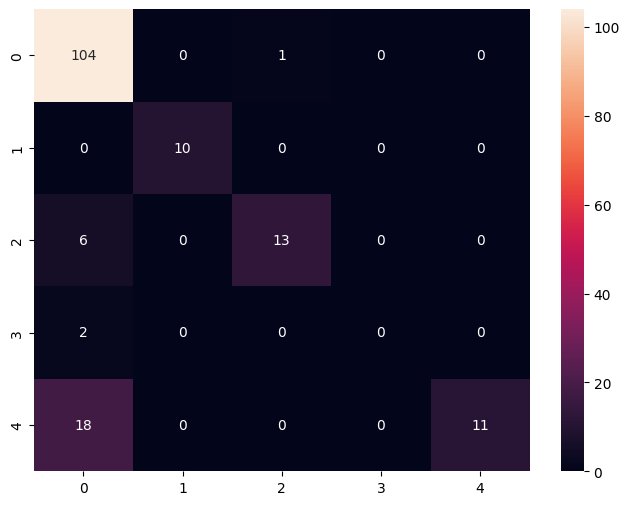

In [31]:
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d') 
plt.show()

Получаем, что для 1 класса было предсказано 104 верно из 105, для 2 класса - 10 из 10, для 3 класса - 13 из 19, для 4 класса 0 из 2, для 5 класса - 11 из 29

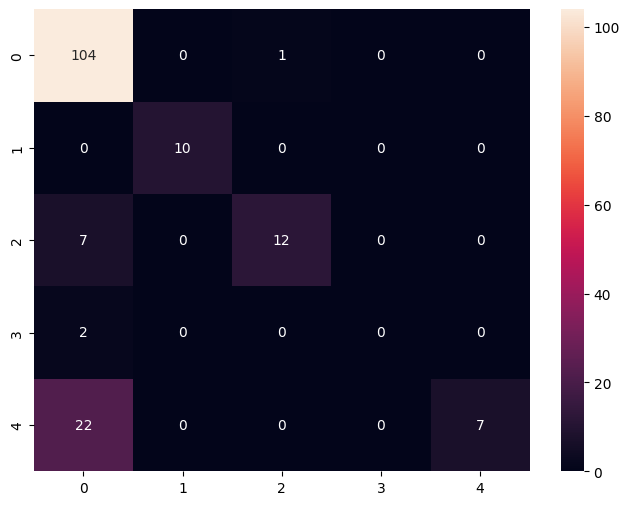

In [36]:
conf = confusion_matrix (y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d') 
plt.show()

Получаем, что для 1 класса было предсказано 104 верно из 105, для 2 класса - 10 из 10, для 3 класса - 12 из 19, для 4 класса 0 из 2, для 5 класса - 7 из 29

### Метод ближайших соседей

In [54]:
%%time
clf = neighbors.KNeighborsClassifier()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.8121212121212121
CPU times: user 2.13 s, sys: 4.19 ms, total: 2.14 s
Wall time: 1.59 s


In [38]:
%%time
clf = neighbors.KNeighborsClassifier()
clf.fit(X_train_b, y_train)
y_pred = clf.predict(X_test_b)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.7272727272727273
CPU times: user 29.6 ms, sys: 3.97 ms, total: 33.6 ms
Wall time: 42.6 ms


In [39]:
%%time
clf = neighbors.KNeighborsClassifier()
clf.fit(X_train_w_a, y_train)
y_pred = clf.predict(X_test_w_a)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.6303030303030303
CPU times: user 17.7 ms, sys: 994 µs, total: 18.7 ms
Wall time: 19.7 ms


In [55]:
table.loc[2] = ['Метод ближайших соседей для TF-IDF', accuracy_score(y_test, y_pred)]

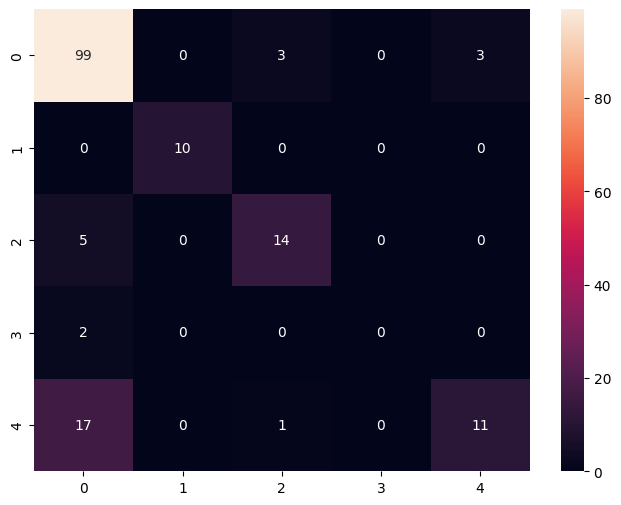

In [42]:
conf = confusion_matrix (y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d') 
plt.show()

Получаем, что для 1 класса было предсказано 99 верно из 105, для 2 класса - 10 из 10, для 3 класса - 14 из 19, для 4 класса 0 из 2, для 5 класса - 11 из 29

### Многослойный перцептрон

In [43]:
%%time
clf = neural_network.MLPClassifier()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print ('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.793939393939394
CPU times: user 7.21 s, sys: 5.47 s, total: 12.7 s
Wall time: 7.21 s


In [56]:
%%time
clf = neural_network.MLPClassifier()
clf.fit(X_train_b, y_train)
y_pred = clf.predict(X_test_b)
print ('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.8181818181818182
CPU times: user 4.57 s, sys: 3.07 s, total: 7.64 s
Wall time: 7.93 s


In [45]:
%%time
clf = neural_network.MLPClassifier()
clf.fit(X_train_w_a, y_train)
y_pred = clf.predict(X_test_w_a)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.6363636363636364
CPU times: user 617 ms, sys: 345 ms, total: 962 ms
Wall time: 1.71 s


In [57]:
table.loc[3] = ['Многослойный перцептрон для BOW', accuracy_score(y_test, y_pred)]

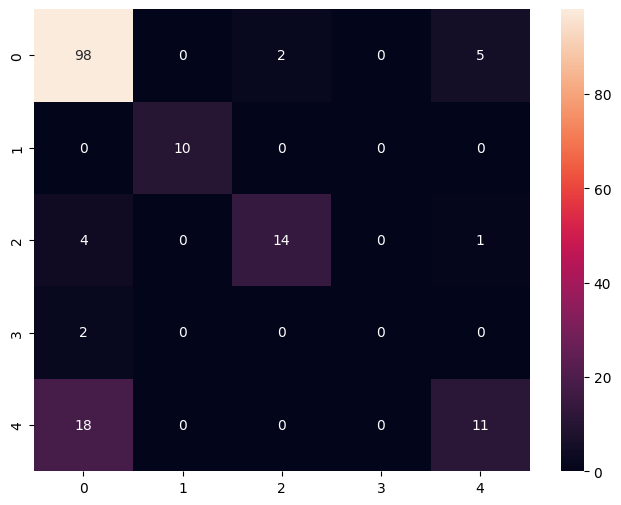

In [48]:
conf = confusion_matrix (y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d') 
plt.show()

Получаем, что для 1 класса было предсказано 98 верно из 105, для 2 класса - 10 из 10, для 3 класса - 14 из 19, для 4 класса 0 из 2, для 5 класса - 11 из 29

### Дерево решений

In [49]:
%%time
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print ('Точность предсказания:', metrics.accuracy_score(y_test, y_pred))

Test Accuracy: 0.7333333333333333
CPU times: user 295 ms, sys: 498 µs, total: 296 ms
Wall time: 349 ms


In [50]:
%%time
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_b, y_train)
y_pred = clf.predict(X_test_b)
print ('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.7151515151515152
CPU times: user 130 ms, sys: 88 µs, total: 130 ms
Wall time: 130 ms


In [51]:
%%time
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_w_a, y_train)
y_pred = clf.predict(X_test_w_a)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.5393939393939394
CPU times: user 6.66 ms, sys: 0 ns, total: 6.66 ms
Wall time: 6.63 ms


Дерево решений показывает очень плохой результат

### Наивный байесовский классификатор

In [52]:
%%time
clf = MultinomialNB()
clf.fit(X_train_b, y_train)
y_pred = clf.predict(X_test_b) 
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.7575757575757576
CPU times: user 6.97 ms, sys: 0 ns, total: 6.97 ms
Wall time: 8.01 ms


In [58]:
%%time
сlf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf) 
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.8121212121212121
CPU times: user 7.56 s, sys: 5.66 s, total: 13.2 s
Wall time: 7.42 s


In [61]:
%%time
clf = MultinomialNB()
clf.fit(X_train_w_a, y_train)
y_pred = clf.predict(X_test_w_a)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.6363636363636364
CPU times: user 5.41 ms, sys: 0 ns, total: 5.41 ms
Wall time: 7.64 ms


In [59]:
table.loc[4] = ['Наивный байесовский классификатор для TF-IDF', accuracy_score(y_test, y_pred)]

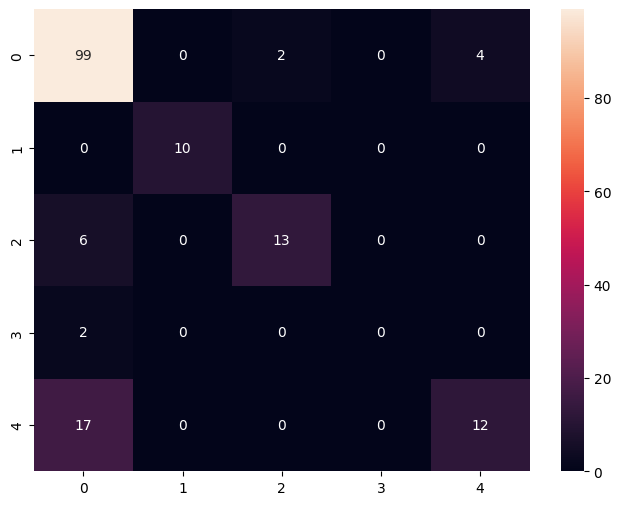

In [60]:
conf = confusion_matrix (y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d') 
plt.show()

Получаем, что для 1 класса было предсказано 99 верно из 105, для 2 класса - 10 из 10, для 3 класса - 13 из 19, для 4 класса 0 из 2, для 5 класса - 12 из 29

### Logistic Regression 

In [62]:
%%time
clf = LogisticRegression()
clf.fit(X_train_w_a, y_train)
y_pred = clf.predict(X_test_w_a)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.6363636363636364
CPU times: user 15.1 ms, sys: 6 µs, total: 15.1 ms
Wall time: 25 ms


In [63]:
%%time
clf = LogisticRegression()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print ('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.8242424242424242
CPU times: user 481 ms, sys: 139 ms, total: 620 ms
Wall time: 472 ms


In [ ]:
# для векторизация BOW достигнут лимит итераций

In [64]:
table.loc[5] = ['Логистическая регрессия для TF-IDF', accuracy_score(y_test, y_pred)]

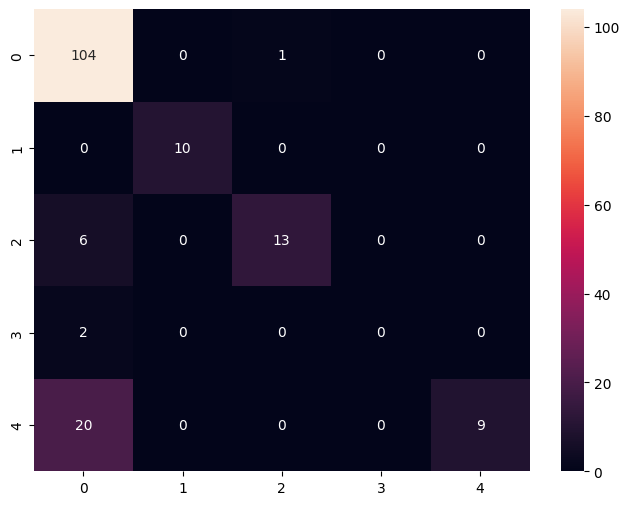

In [65]:
conf = confusion_matrix (y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d') 
plt.show()

Получаем, что для 1 класса было предсказано 104 верно из 105, для 2 класса - 9 из 10, для 3 класса - 13 из 19, для 4 класса 0 из 2, для 5 класса - 9 из 29

###  Пассивно-агрессивный классификатор


In [67]:
%%time
clf = linear_model.PassiveAggressiveClassifier()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print ('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.8363636363636363
CPU times: user 31 ms, sys: 0 ns, total: 31 ms
Wall time: 30.8 ms


In [90]:
%%time
clf = linear_model.PassiveAggressiveClassifier()
clf.fit(X_train_b, y_train)
y_pred = clf.predict(X_test_b)
print ('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.8121212121212121
CPU times: user 42 ms, sys: 838 µs, total: 42.8 ms
Wall time: 59.8 ms


In [71]:
%%time
clf = linear_model.PassiveAggressiveClassifier()
clf.fit(X_train_w_a, y_train)
y_pred = clf.predict(X_test_w_a)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.6303030303030303
CPU times: user 9.61 ms, sys: 112 µs, total: 9.72 ms
Wall time: 10.2 ms


In [68]:
table.loc[6] = ['Пассивно-агрессивный классификатор для TF-IDF', accuracy_score(y_test, y_pred)]

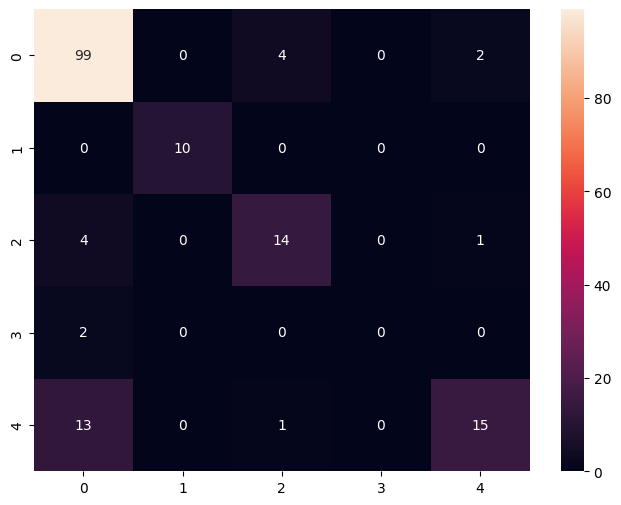

In [69]:
conf = confusion_matrix (y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d') 
plt.show()

Получаем, что для 1 класса было предсказано 99 верно из 105, для 2 класса - 9 из 10, для 3 класса - 14 из 19, для 4 класса 0 из 2, для 5 класса - 15 из 29

In [95]:
table.loc[9] = ['Пассивно-агрессивный классификатор для BOW', accuracy_score(y_test, y_pred)]

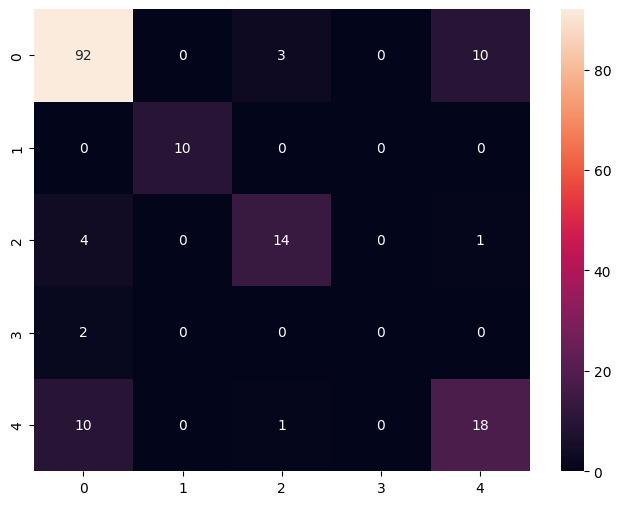

In [96]:
conf = confusion_matrix (y_test, y_pred) # матрица ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d') 
plt.show()

Получаем, что для 1 класса было предсказано 92 верно из 105, для 2 класса - 9 из 10, для 3 класса - 14 из 19, для 4 класса 0 из 2, для 5 класса - 18 из 29

### Гребневый классификатор

In [72]:
%%time
clf = linear_model.RidgeClassifierCV()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print ('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.8424242424242424
CPU times: user 250 ms, sys: 79 ms, total: 329 ms
Wall time: 200 ms


In [75]:
%%time
clf = linear_model.RidgeClassifierCV()
clf.fit(X_train_b, y_train)
y_pred = clf.predict(X_test_b)
print ('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.7636363636363637
CPU times: user 221 ms, sys: 80.4 ms, total: 302 ms
Wall time: 177 ms


In [76]:
%%time
clf = linear_model.RidgeClassifierCV()
clf.fit(X_train_w_a, y_train)
y_pred = clf.predict(X_test_w_a)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.6363636363636364
CPU times: user 6.64 ms, sys: 121 µs, total: 6.76 ms
Wall time: 17.2 ms


In [73]:
table.loc[7] = ['Гребневый классификатор для TF-IDF', accuracy_score(y_test, y_pred)]

Предсказание с данной моделью дает хорошую точность

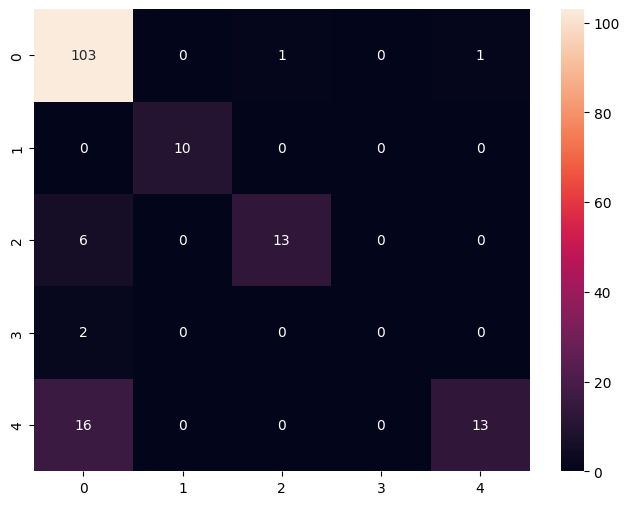

In [74]:
conf = confusion_matrix (y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d') 
plt.show()

Получаем, что для 1 класса было предсказано 103 верно из 105, для 2 класса - 10 из 10, для 3 класса - 13 из 19, для 4 класса 0 из 2, для 5 класса - 13 из 29

### Случайный лес

In [77]:
%%time
clf = ensemble.RandomForestClassifier()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print ('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.7878787878787878
CPU times: user 603 ms, sys: 3.1 ms, total: 606 ms
Wall time: 612 ms


In [78]:
%%time
clf = ensemble.RandomForestClassifier()
clf.fit(X_train_b, y_train)
y_pred = clf.predict(X_test_b)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.8
CPU times: user 472 ms, sys: 1.24 ms, total: 474 ms
Wall time: 475 ms


In [81]:
%%time
clf = ensemble.RandomForestClassifier()
clf.fit(X_train_w_a, y_train)
y_pred = clf.predict(X_test_w_a)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.5393939393939394
CPU times: user 242 ms, sys: 194 µs, total: 242 ms
Wall time: 247 ms


In [79]:
table.loc[8] = ['Случайный лес для TF-IDF', accuracy_score(y_test, y_pred)]

Предсказание с данной моделью дает хорошую точность

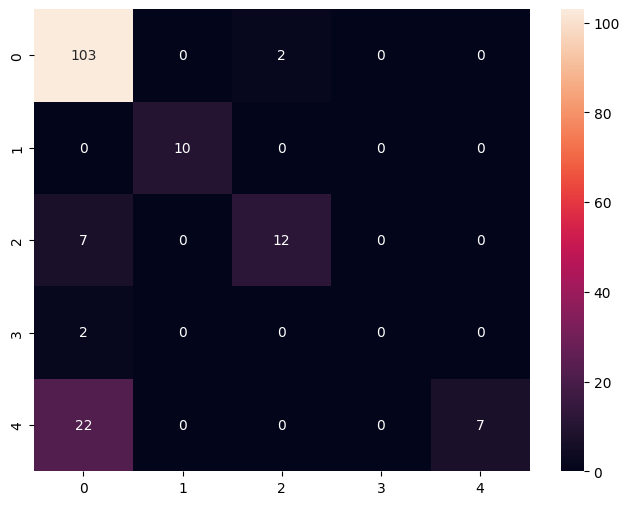

In [80]:
conf = confusion_matrix (y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d') 
plt.show()

Получаем, что для 1 класса было предсказано 103 верно из 105, для 2 класса - 10 из 10, для 3 класса - 12 из 19, для 4 класса 0 из 2, для 5 класса - 7 из 29

### Беггинг

In [82]:
%%time
clf = ensemble.BaggingClassifier()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print ('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.7878787878787878
CPU times: user 1.47 s, sys: 0 ns, total: 1.47 s
Wall time: 1.59 s


In [83]:
%%time
clf = ensemble.BaggingClassifier()
clf.fit(X_train_b, y_train)
y_pred = clf.predict(X_test_b)
print ('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.7636363636363637
CPU times: user 842 ms, sys: 1.64 ms, total: 844 ms
Wall time: 843 ms


In [84]:
%%time
clf = ensemble.BaggingClassifier()
clf.fit(X_train_w_a, y_train)
y_pred = clf.predict(X_test_w_a)
print('Точность предсказания:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.5333333333333333
CPU times: user 30.6 ms, sys: 0 ns, total: 30.6 ms
Wall time: 30.9 ms


Предсказание с данной моделью дает результат хуже

### Градиентный бустинг

Градиентный бустинг - метод, который строит множество слабых моделей (например, деревьев решений) и улучшает их, минимизируя ошибку градиентного спуска.

In [97]:
%%time
clf = ensemble.GradientBoostingClassifier()

clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
accuracy_score(y_test, y_pred)

CPU times: user 17.1 s, sys: 15.6 ms, total: 17.2 s
Wall time: 21.9 s


0.7818181818181819

In [98]:
%%time
clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train_b, y_train)
y_pred = clf.predict(X_test_b)
accuracy_score(y_test, y_pred)

CPU times: user 6.28 s, sys: 10.3 ms, total: 6.29 s
Wall time: 6.59 s


0.793939393939394

In [99]:
%%time
clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train_w_a, y_train)
y_pred = clf.predict(X_test_w_a)
accuracy_score(y_test, y_pred)

CPU times: user 917 ms, sys: 4.74 ms, total: 921 ms
Wall time: 1.52 s


0.6060606060606061

In [102]:
table.iloc[:9]

,Название модели,Точность
1,Метод опорных векторов с линейным ядром для TF...,0.836364
0,Метод опорных векторов с ядром rbf для TF-IDF,0.806061
2,Метод ближайших соседей для TF-IDF,0.812121
3,Многослойный перцептрон для BOW,0.818182
4,Наивный байесовский классификатор для TF-IDF,0.812121
5,Логистическая регрессия для TF-IDF,0.824242
6,Пассивно-агрессивный классификатор для TF-IDF,0.836364
7,Гребневый классификатор для TF-IDF,0.842424
8,Пассивно-агрессивный классификатор для BOW,0.812121


Вывод: самыми лучшим векторизатором является TF-IDF, а моделями Метод опорных векторов с линейным и rbf ядрами, Метод ближайших соседей, Многослойный перцептрон, Наивный байесовский классификатор, Логистическая регрессия, Пассивно-агрессивный классификатор, Гребневый классификатор

# Улучшение модели

## Кросс-валидация

Проверим работу наилучших моделей с помощью кросс-валидации

In [103]:
# Создаём k-блочное разбиение (KFold)
kf = KFold(n_splits = 5,shuffle=True, random_state=15)

In [104]:
X = morph_data

In [105]:
#разбиение на блоки

for i, (train_index, test_index) in enumerate(kf.split(y)):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [106]:
%%time
# Метод опорных векторов с линейным ядром для TF-IDF
cv_results = cross_val_score(svm.SVC(kernel='linear'),           
                             vectorizer.fit_transform(X),                     
                             y,                           
                             n_jobs=-1)             

print("Кросс-валидация: ", cv_results)
print("Среднее по кросс-валидации: ", cv_results.mean())

Кросс-валидация:  [0.70909091 0.78181818 0.84848485 0.82424242 0.75151515]
Среднее по кросс-валидации:  0.783030303030303
CPU times: user 481 ms, sys: 93.1 ms, total: 574 ms
Wall time: 5.4 s


In [107]:
%%time
# Метод опорных векторов с rbf ядром для TF-IDF
cv_results = cross_val_score(svm.SVC(kernel='rbf'),           
                             vectorizer.fit_transform(X),                     
                             y,                           
                             n_jobs=-1)             

print("Кросс-валидация: ", cv_results)
print("Среднее по кросс-валидации: ", cv_results.mean())

Кросс-валидация:  [0.72727273 0.75757576 0.83030303 0.8        0.75757576]
Среднее по кросс-валидации:  0.7745454545454546
CPU times: user 280 ms, sys: 6.25 ms, total: 286 ms
Wall time: 4.56 s


In [109]:
%%time
# Метод ближайших соседей для TF-IDF
cv_results = cross_val_score(neighbors.KNeighborsClassifier(),           
                             vect.fit_transform(X),                     
                             y,                           
                             n_jobs=-1)             

print("Кросс-валидация: ", cv_results)
print("Среднее по кросс-валидации: ", cv_results.mean())

Кросс-валидация:  [0.43030303 0.73333333 0.78787879 0.76969697 0.51515152]
Среднее по кросс-валидации:  0.6472727272727272
CPU times: user 442 ms, sys: 4.91 ms, total: 447 ms
Wall time: 683 ms


In [108]:
%%time
# Многослоный перцептрон для BOW
cv_results = cross_val_score(neural_network.MLPClassifier(),           
                             vect.fit_transform(X),                     
                             y,                           
                             n_jobs=-1)             

print("Кросс-валидация: ", cv_results)
print("Среднее по кросс-валидации: ", cv_results.mean())

Кросс-валидация:  [0.66060606 0.73333333 0.85454545 0.80606061 0.73333333]
Среднее по кросс-валидации:  0.7575757575757576
CPU times: user 375 ms, sys: 16.8 ms, total: 392 ms
Wall time: 25.6 s


In [110]:
%%time
# Наивный байесовский классификатор для TF-IDF
cv_results = cross_val_score(MultinomialNB(),           
                             vectorizer.fit_transform(X),                     
                             y,                           
                             n_jobs=-1)             

print("Кросс-валидация: ", cv_results)
print("Среднее по кросс-валидации: ", cv_results.mean())

Кросс-валидация:  [0.71515152 0.76969697 0.81818182 0.76363636 0.79393939]
Среднее по кросс-валидации:  0.7721212121212122
CPU times: user 457 ms, sys: 870 µs, total: 458 ms
Wall time: 524 ms


In [111]:
%%time
# Логистическая регрессия для TF-IDF
cv_results = cross_val_score(LogisticRegression(),           
                             vectorizer.fit_transform(X),                     
                             y,                           
                             n_jobs=-1)             

print("Кросс-валидация: ", cv_results)
print("Среднее по кросс-валидации: ", cv_results.mean())

Кросс-валидация:  [0.72727273 0.75757576 0.84242424 0.79393939 0.76363636]
Среднее по кросс-валидации:  0.776969696969697
CPU times: user 262 ms, sys: 3.87 ms, total: 266 ms
Wall time: 771 ms


In [112]:
%%time
# Пассивно-агрессивный классификатор для TF-IDF 
cv_results = cross_val_score(linear_model.PassiveAggressiveClassifier(),           
                             vectorizer.fit_transform(X),                     
                             y,                           
                             n_jobs=-1)             

print("Кросс-валидация: ", cv_results)
print("Среднее по кросс-валидации: ", cv_results.mean())

Кросс-валидация:  [0.66666667 0.66666667 0.8        0.8        0.72121212]
Среднее по кросс-валидации:  0.730909090909091
CPU times: user 453 ms, sys: 4.39 ms, total: 458 ms
Wall time: 1.09 s


In [114]:
%%time
# Пассивно-агрессивный классификатор для BOW
cv_results = cross_val_score(linear_model.PassiveAggressiveClassifier(),           
                             vect.fit_transform(X),                     
                             y,                           
                             n_jobs=-1)             

print("Кросс-валидация: ", cv_results)
print("Среднее по кросс-валидации: ", cv_results.mean())

Кросс-валидация:  [0.59393939 0.64242424 0.76969697 0.8        0.71515152]
Среднее по кросс-валидации:  0.7042424242424242
CPU times: user 433 ms, sys: 6.69 ms, total: 440 ms
Wall time: 749 ms


In [115]:
%%time
# Гребневый классификатор для TF-IDF 
cv_results = cross_val_score(linear_model.RidgeClassifierCV(),           
                             vectorizer.fit_transform(X),                     
                             y,                           
                             n_jobs=-1)             

print("Кросс-валидация: ", cv_results)
print("Среднее по кросс-валидации: ", cv_results.mean())

Кросс-валидация:  [0.73333333 0.76363636 0.84848485 0.81818182 0.76363636]
Среднее по кросс-валидации:  0.7854545454545455
CPU times: user 263 ms, sys: 5.05 ms, total: 268 ms
Wall time: 983 ms


Получаем, что наилучшие метрики имеет Метод опорных векторов с линейным ядром и Гребневый классификатор

## Grid Search

GridSearchCV – инструмент для автоматического подбора параметров для моделей ML

In [134]:
# Метод опорных векторов с линейным ядром 
parametrs = { 'random_state': range (2,100,2) }

In [135]:
clf = svm.SVC(kernel='linear')

In [136]:
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid={'random_state': range(2, 100, 2)})

In [137]:
grid.best_params_

{'random_state': 2}

In [141]:
%%time
clf = svm.SVC(kernel='linear', random_state=2) 
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('Test Accuracy:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.7212121212121212
CPU times: user 1.13 s, sys: 2.29 ms, total: 1.14 s
Wall time: 2.07 s


In [127]:
%%time
clf = svm.SVC(kernel='linear') 
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('Test Accuracy:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.7212121212121212
CPU times: user 932 ms, sys: 1.32 ms, total: 933 ms
Wall time: 936 ms


In [157]:
# Гребневый классификатор
parametrs = {'cv': range (2,45,2)}

In [158]:
clf = linear_model.RidgeClassifierCV()

In [ ]:
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(X_train_tfidf, y_train)

In [ ]:
grid.best_params_

In [126]:
%%time
clf = linear_model.RidgeClassifierCV()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('Test Accuracy:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.7212121212121212
CPU times: user 278 ms, sys: 161 ms, total: 439 ms
Wall time: 668 ms


Таким образом, наилучшая модель - Метод опорных векторов с линейным ядром дает наилучшую точность - 78%

# Нейросеть

Виды функции активации: линейная, ступенчатая, сигмоидная, тангенциальная, выпрямительная

Обучение - процесс оптимизации, в котором минимизируется ошибка предсказания, и сеть достигает требуемого уровня точности.

С помощью дополнительных скрытых слоев можно улучшить гибкость модели


In [120]:
neural = models.Sequential([layers.Dense(32, activation='relu', input_shape=(X_train_tfidf.shape[1],)), 
layers.Dense(1, activation='sigmoid')])
neural.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [121]:
X_train_tfidf.shape, X_test_tfidf.shape, y_train.shape

((660, 2061), (165, 2061), (660,))

Если целевым параметром обучения модели нейронной сети является минимизация функции потерь, то оптимальным можно считать количество эпох в области выхода на плато кривых обучения и валидации на графике этой функции потерь.

In [124]:
neural.fit(X_train_tfidf, y_train, epochs=5, batch_size=128) # batch_size - делит эпоху датасет на маленькие партии

Epoch 1/5
6/6 [==============================] - 0s 6ms/step - loss: -2.0193 - accuracy: 0.6152
Epoch 2/5
6/6 [==============================] - 0s 9ms/step - loss: -2.4466 - accuracy: 0.6152
Epoch 3/5
6/6 [==============================] - 0s 13ms/step - loss: -2.8707 - accuracy: 0.6152
Epoch 4/5
6/6 [==============================] - 0s 15ms/step - loss: -3.3055 - accuracy: 0.6152
Epoch 5/5
6/6 [==============================] - 0s 9ms/step - loss: -3.7739 - accuracy: 0.6152


In [125]:
test_loss, test_accuracy = neural.evaluate(X_test_tfidf, y_test)
print(f"Точность модели нейросети: {test_accuracy * 100:.2f}%")

6/6 [==============================] - 0s 6ms/step - loss: -3.0920 - accuracy: 0.7212
Точность модели нейросети: 72.12%


In [128]:
# точность предсказания нейросети хорошего уровня

# Выводы

В исследовательской работе было протестированно 11 простых моделей классификации и 1 нейронная сеть. Все алгоритмы демонстрируют среднюю точность от 60 % до 80%,наибольшую точность демонстрирует алгоритм градиентного бустинга. Также для задач анализа потока новостей используются различные векторизаторы данных, которые влияют наточность предсказания в том числе. В моей задачи используются BOW, TF-IDF, Word2Vec. Точность наилучшей простой модели составила: 78% (Метод опорных векторов с линейным ядром)

Также для анализа текстов используются нейронные сети. Моя модель получила следующую точность: 72.12%

# Список литературы

1. https://towardsdatascience.com/text-vectorization-bag-of-words-bow-441d1bfce897 
2. https://datastart.ru/blog/read/plavnoe-vvedenie-v-natural-language-processing-nlp
3. https://rare-technologies.com/word2vec-tutorial/#app
4. https://www.youtube.com/watch?v=U0LOSHY7U5Q 
5. https://www.analyticsvidhya.com/blog/2022/03/fake-news-classification-using-deep-learning/
6. https://trends.rbc.ru/trends/industry/641157be9a7947d3401fa3e8